# 1.NSCLC Sex-stratified SC Analysis

## Data selection, pseudobulk, create input for DESEQ2

In [44]:
import scanpy as sc

In [45]:
import warnings
import numpy as np
import pandas as pd 
import scanpy as sc
#import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
#import altair as alt
#import pertpy as pt
#from pandas.api.types import is_categorical_dtype
#from pandas import CategoricalDtype

In [46]:
# Setup
import importlib
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

#from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

import sccoda.datasets as scd

ModuleNotFoundError: No module named 'sccoda'

In [3]:

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from statannotations.Annotator import Annotator

In [ ]:
path = "/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp"
input_path    = f"{path}/data/local.h5ad"

In [ ]:
adata = sc.read_h5ad(input_path) 

In [ ]:
nsclc_chrom = pd.read_csv(f"{path}/out/007_re_analysis/tables/input/adata_var_nsclc_chrom.csv")

In [ ]:
adata

In [ ]:
adata.obs.disease.value_counts()

In [ ]:
adata.obs.tumor_stage.value_counts()

In [ ]:
adata.obs.sex.value_counts()

In [ ]:
adata.obs.origin.value_counts()

### 01.SELECT ONLY male, female & tumor, normal_adjacent

In [ ]:
adata = adata[(adata.obs["disease"] != "normal") & (adata.obs["disease"] != "chronic obstructive pulmonary disease")] #exclude normal and COPD samples
adata = adata[adata.obs["tumor_stage"].notna()] #exclude samples without tumor stage
adata = adata[(adata.obs["sex"]=="male")| (adata.obs["sex"]=="female")]

In [ ]:
adata = adata[(adata.obs["origin"]=="tumor_primary")| (adata.obs["origin"]=="normal_adjacent")]

In [ ]:
adata.obs.disease.value_counts()

In [ ]:
adata.obs.tumor_stage.value_counts()

In [ ]:
adata.obs.sex.value_counts()

In [ ]:
adata.obs.origin.value_counts()

### 02.CELL TPYE RE-CLASIFICATION 

In [ ]:
adata.obs.cell_type.value_counts()

In [ ]:
adata.obs.cell_type_major.value_counts()

In [ ]:
cells_of_interest=['alveolar macrophage', 'neutrophil',
 'macrophage','malignant cell',
 'B cell',
  'regulatory T cell',
'CD4-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta T cell',
 'neutrophils','epithelial cell of lung','multi-ciliated epithelial cell' ]
subset_adata = adata[adata.obs["cell_type"].isin(cells_of_interest)] 


In [ ]:
set(subset_adata.obs.cell_type)

In [ ]:
set(subset_adata.obs.cell_type_major)

In [ ]:
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['epithelial cell of lung','multi-ciliated epithelial cell',], 'epithelial cell')
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['alveolar macrophage'], 'macrophage')
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['CD4-positive, alpha-beta T cell'], 'CD4+ T cell')
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['CD8-positive, alpha-beta T cell'], 'CD8+ T cell')

In [ ]:
set(subset_adata.obs.cell_type)

In [ ]:
subset_adata

In [ ]:
subset_adata.obs.disease.value_counts()

In [ ]:
adata

## PAIRED SAMPLES REMOVE NSCLC 

In [ ]:
subset_adata = subset_adata[(subset_adata.obs["disease"]!="non-small cell lung carcinoma")]

In [ ]:
subset_adata = subset_adata[(subset_adata.obs["disease"]!="squamous cell lung carcinoma")]

In [ ]:
df_grouped = subset_adata.obs.groupby(["origin","donor_id"]).count()

In [ ]:
df_grouped.reset_index(inplace= True)

In [ ]:
df_grouped_normal = df_grouped[df_grouped["origin"]=="normal_adjacent"]

In [ ]:
df_grouped_normal = df_grouped_normal[df_grouped_normal['sample'] != 0]

In [ ]:
df_grouped_tumor = df_grouped[df_grouped["origin"]=="tumor_primary"]

In [ ]:
df_grouped_tumor = df_grouped_tumor[df_grouped_tumor['sample'] != 0]

In [ ]:
list(set(df_grouped_tumor.donor_id))

In [ ]:
common_ids =list(set(df_grouped_normal.donor_id)& set(df_grouped_tumor.donor_id))

In [ ]:
len(common_ids)

In [ ]:
paired_adata = subset_adata[subset_adata.obs['donor_id'].isin(common_ids)].copy()

In [ ]:
df = paired_adata.obs#
origin_counts = df.groupby('origin')['donor_id'].nunique().reset_index()
origin_counts.columns = ['origin', 'count']

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=origin_counts, x='origin', y='count', palette='viridis')
plt.xlabel('Origin')
plt.ylabel('Number of Unique Donor IDs')
plt.title('Number of Unique Donor IDs per Origin')
plt.show()

In [ ]:
df = paired_adata.obs#
origin_counts = df.groupby('disease')['donor_id'].nunique().reset_index()
origin_counts.columns = ['disease', 'count']

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=origin_counts, x='disease', y='count', palette='viridis')
plt.xlabel('disease')
plt.ylabel('Number of Unique Donor IDs')
plt.title('Number of Unique Donor IDs per disease')
plt.show()

In [ ]:
#paired_adata.write_h5ad("paired_adata.h5ad")

In [47]:
paired_adata = sc.read_h5ad("paired_adata.h5ad")

In [122]:
df_num = paired_adata.obs[["cell_type","sex"]].value_counts()

In [124]:
df_num.to_csv("cell_count.csv")

In [ ]:
#data_all.write_h5ad("data_all.h5ad")

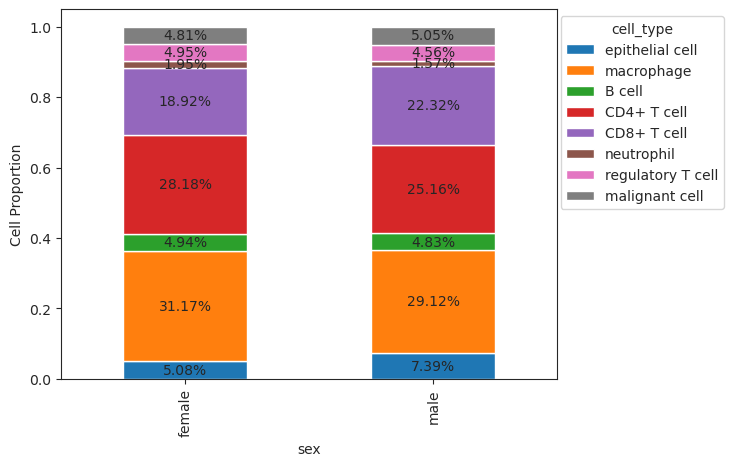

In [121]:
tmp = pd.crosstab(paired_adata.obs['cell_type'], paired_adata.obs['sex'], normalize='columns').T

# Plotting the stacked barplot
ax = tmp.plot(kind='bar', stacked=True)

# Annotating percentages
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.text(x + width / 2, y + height / 2, f'{height:.2%}', ha='center', va='center')

# Adjusting legend
ax.legend(title='cell_type', bbox_to_anchor=(1.35, 1), loc='upper right')
# Adding y-axis label
ax.set_ylabel('Cell Proportion')


#plt.tight_layout()

# Save the plot
plt.savefig('stacked_barplot_with_percentages.png', bbox_inches='tight')
# Show the plot
plt.show()

In [59]:
val_counts = paired_adata.obs['cell_type'].value_counts()

In [60]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize = (1,4))
ov.pl.cellproportion(adata=adata,celltype_clusters='clusters',
                    groupby='age(days)',legend=True,ax=ax)

macrophage           104269
CD4+ T cell           92487
CD8+ T cell           70391
epithelial cell       21038
malignant cell        16939
B cell                16853
regulatory T cell     16458
neutrophil             6146
Name: cell_type, dtype: int64

## SUMMARY 
- Filtered for male, female & tumor, normal_adjacent
- Filtered and reclassified cells of interest: 'B cell','CD4+ T cell', 'CD8+ T cell', 'epithelial cell', 'macrophage', 'malignant cell', 'neutrophil', 'regulatory Tcell'
- Filtered to exclude samples coming from NSCLC
- Filtered for PAIRED SAMPLES (82 donor_id that have normal_adjacent and tumor_primary  samples)
- KEEP LUADN AND LUSC

In [ ]:
frac_by_condition = (
    paired_adata.obs.groupby(["dataset", "cell_type", "tumor_stage", "donor_id","origin"])
    .apply(lambda x: x.value_counts("sex", normalize=False))
    .reset_index(name="n_cells")
    .assign(condition=lambda x: x["cell_type"].astype(str))
)

In [ ]:
frac_by_condition

In [ ]:
frac_pivot = (
    frac_by_condition.pivot(
        index=["donor_id", "dataset", "sex", "tumor_stage","origin"],
        columns="cell_type",
        values="n_cells",
    )
    .reset_index()
    #.drop(columns="other")
)


In [ ]:
frac_pivot

In [ ]:
data_all = dat.from_pandas(
    frac_pivot, covariate_columns=["donor_id", "dataset", "sex", "tumor_stage","origin"]
)

In [ ]:
data_all.obs["sex"] = pd.Categorical(
    data_all.obs["sex"], categories=["male", "female"]
)

In [ ]:
data_all._sanitize()

In [ ]:
data_all

In [ ]:
#data_all.write_h5ad("data_all.h5ad")

In [5]:
data_all = sc.read_h5ad("data_all.h5ad")

/tmp/ipykernel_226175/1574092851.py:64: RuntimeWarning: invalid value encountered in divide
  X = data.X/sample_sums


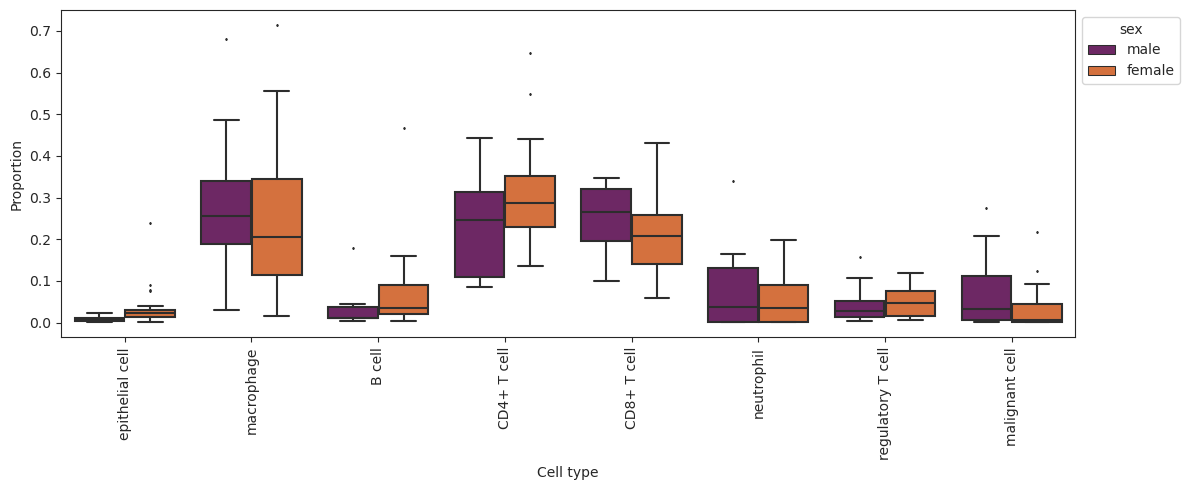

In [36]:
boxplots(data_all, feature_name="sex", figsize=(12, 5), cmap = "inferno")

plt.savefig( "cell_proportion_nosig.png")


In [ ]:
pd.DataFrame.iteritems = pd.DataFrame.items

/tmp/ipykernel_226175/3619146285.py:64: RuntimeWarning: invalid value encountered in divide
  X = data.X/sample_sums
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use

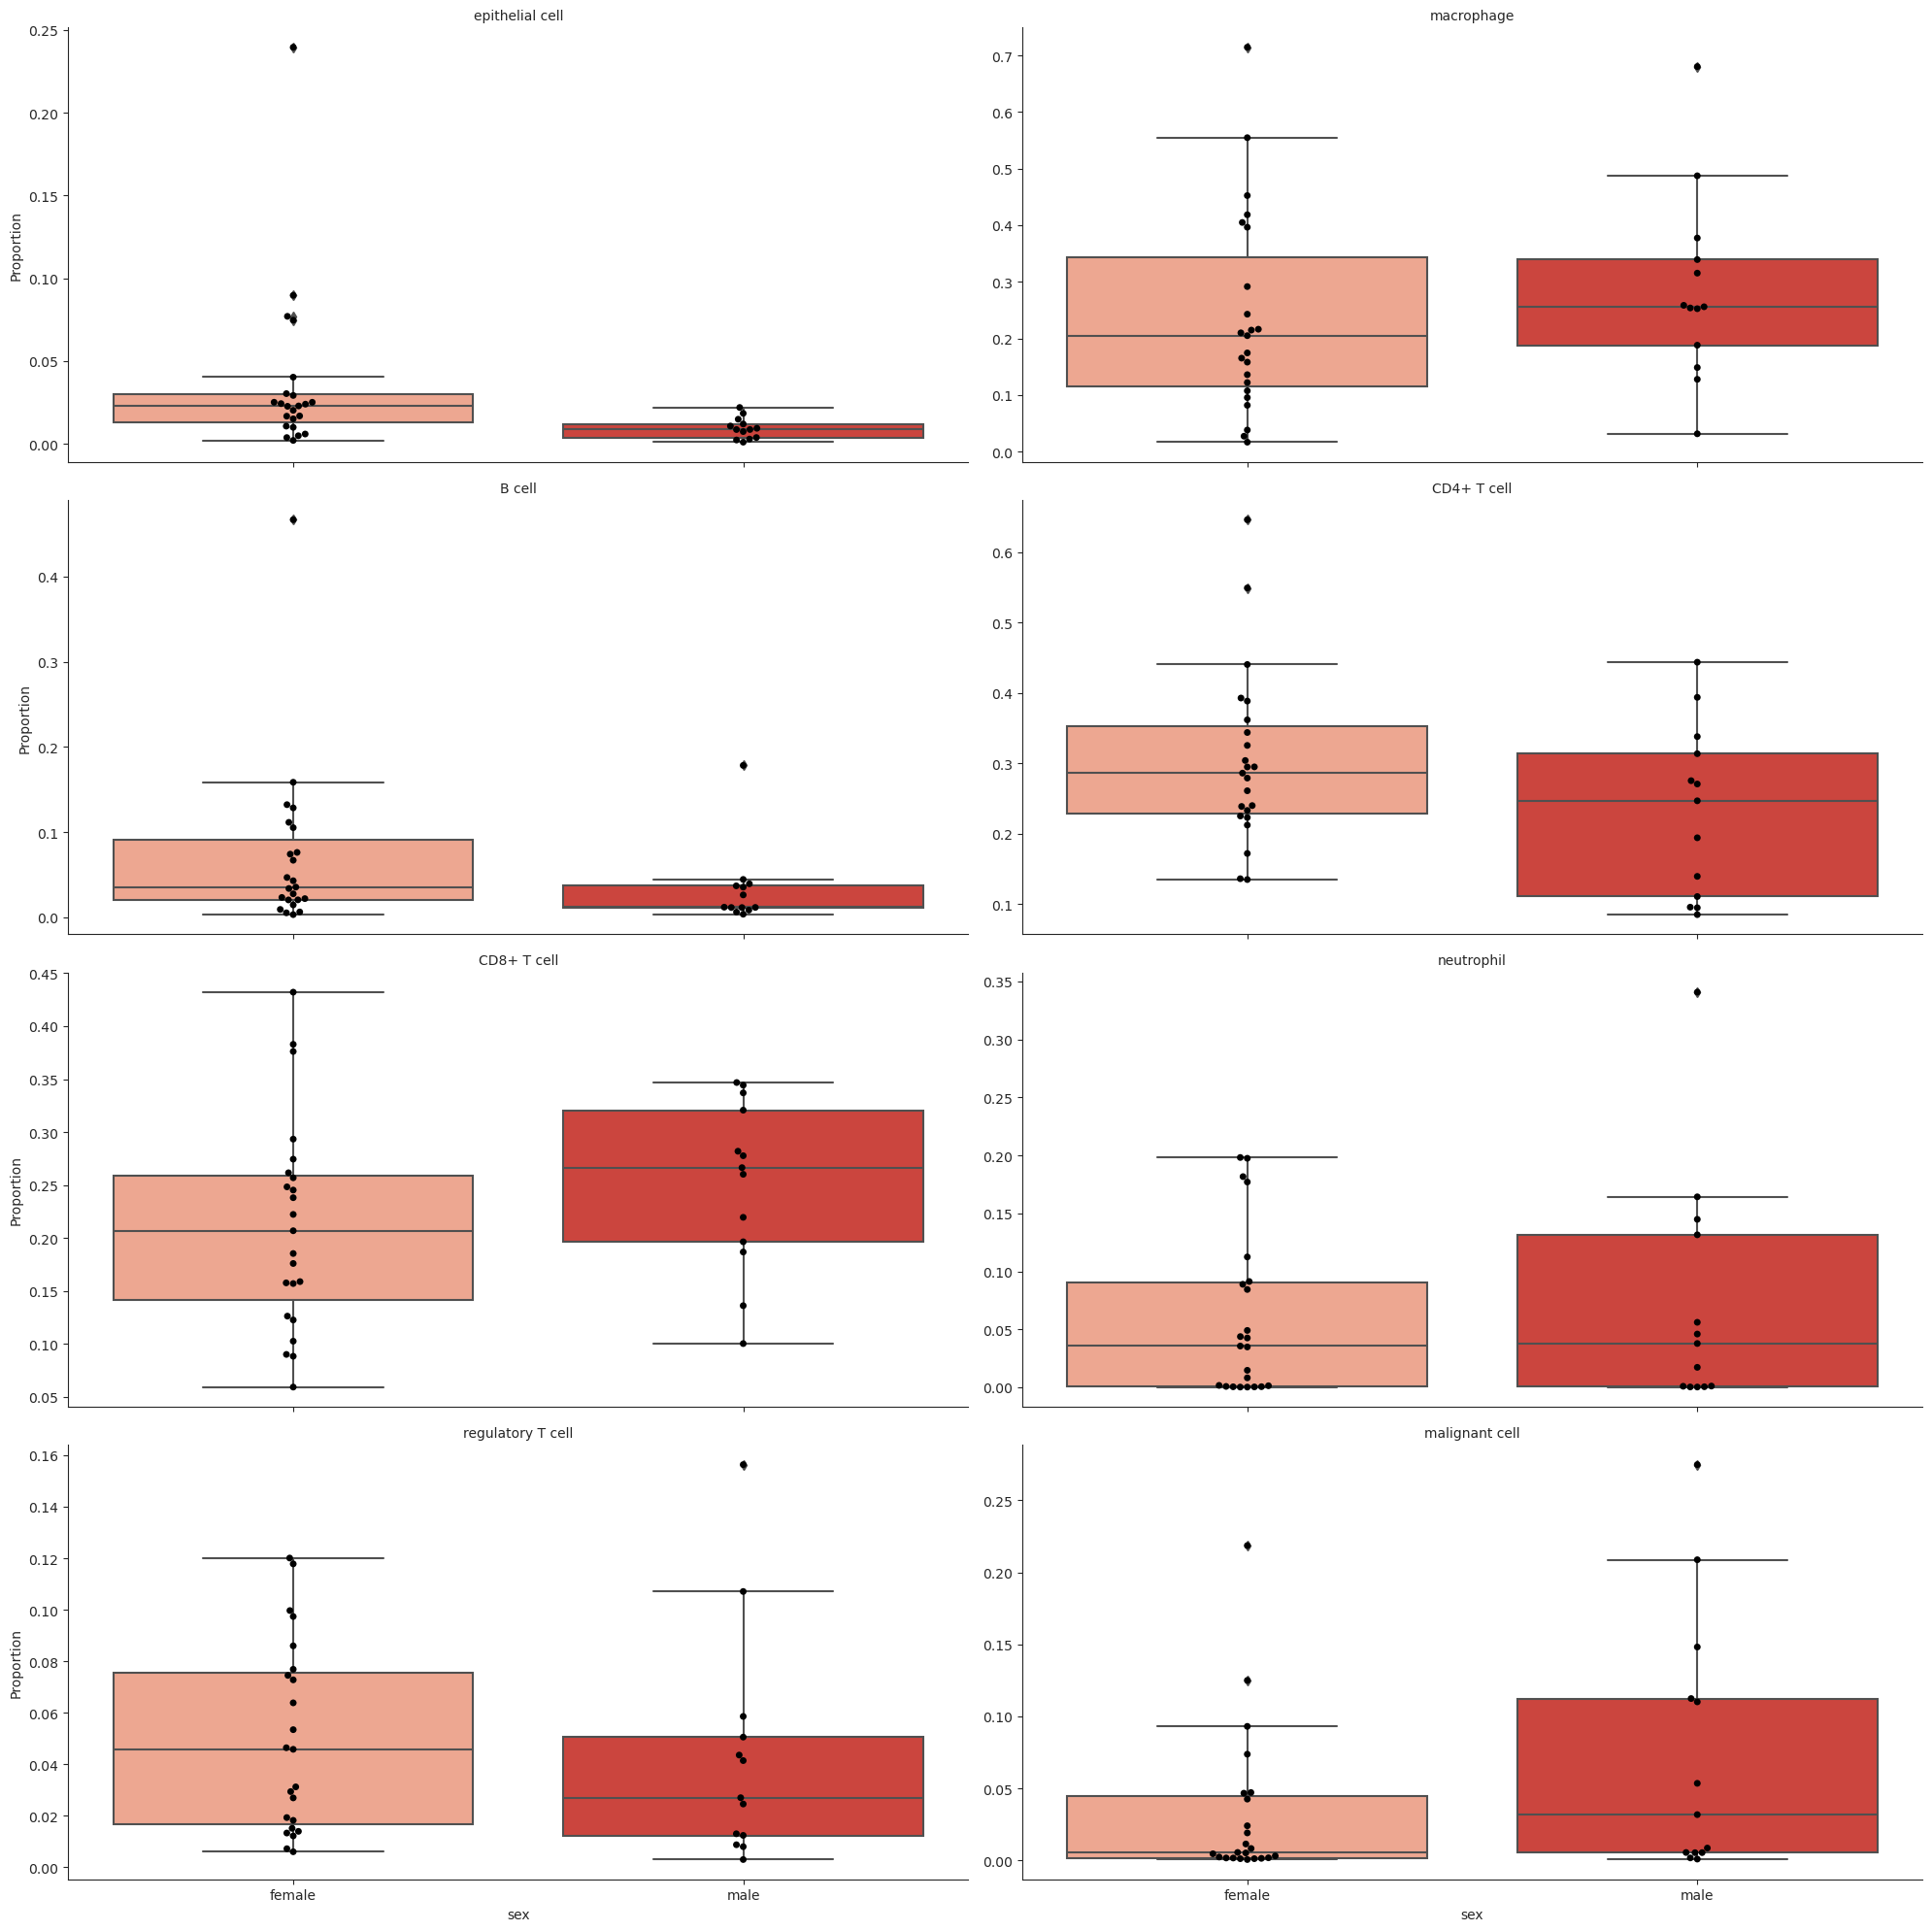

In [29]:
boxplots(
    data_all,
    feature_name="sex",
    plot_facets=True,
   # y_scale="log",
    add_dots=True,
    cmap="Reds",
)

In [ ]:
viz.boxplots(
    data_all,
    feature_name="sex",
    plot_facets=False,
   # y_scale="log",
    add_dots=True,
    cmap="Reds",
)

In [ ]:
ax = viz.boxplots(
    data_all,
    feature_name="sex",
    plot_facets=True,
   y_scale="log",
    #args_swarmplot= {hue:"dataset"},
    add_dots=True,
    cmap="Reds",
)



In [43]:
data_all.obs

,donor_id,dataset,sex,tumor_stage,origin
0,Goveia_Carmeliet_2020_patient_45,Goveia_Carmeliet_2020,female,early,normal_adjacent
1,Goveia_Carmeliet_2020_patient_45,Goveia_Carmeliet_2020,female,early,tumor_primary
2,Goveia_Carmeliet_2020_patient_45,Goveia_Carmeliet_2020,male,early,normal_adjacent
3,Goveia_Carmeliet_2020_patient_45,Goveia_Carmeliet_2020,male,early,tumor_primary
4,Goveia_Carmeliet_2020_patient_46,Goveia_Carmeliet_2020,female,early,normal_adjacent
...,...,...,...,...,...
231,UKIM-V_P1,UKIM-V,male,early,tumor_primary
232,UKIM-V_P3,UKIM-V,female,early,normal_adjacent
233,UKIM-V_P3,UKIM-V,female,early,tumor_primary
234,UKIM-V_P3,UKIM-V,male,early,normal_adjacent


In [ ]:
import numpy as np

In [ ]:
data = data_all
feature_name="sex"
y_scale = "relative"
plot_facets= True
add_dots= True
cell_types = None
args_boxplot= {}
args_swarmplot= {}
figsize= None
dpi= 100
cmap= "Blues"
plot_legend = True
level_order = None

In [ ]:
#plot_df.to_csv("plot_df.csv")

In [38]:
plot_df  = pd.read_csv("plot_df.csv", index_col=0)

In [ ]:
annot.configure()

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

# Assuming 'data_all' is already defined
data = data_all
feature_name = "sex"
y_scale = "relative"
plot_facets = True
add_dots = True
cell_types = None
args_boxplot = {}
args_swarmplot = {}
figsize = None
dpi = 100
cmap = "Blues"
plot_legend = True
level_order = None

sample_sums = np.sum(data.X, axis=1, keepdims=True)
X = data.X / sample_sums
value_name = "Proportion"

count_df = pd.DataFrame(X, columns=data.var.index, index=data.obs.index).\
    merge(data.obs[feature_name], left_index=True, right_index=True)
plot_df = pd.melt(count_df, id_vars=feature_name, var_name="Cell type", value_name=value_name)
if cell_types is not None:
    plot_df = plot_df[plot_df["Cell type"].isin(cell_types)]

pairs = [("male", "female")]  # Define pairs for statistical comparisons

if plot_facets:

    if level_order is None:
        level_order = pd.unique(plot_df[feature_name])

    K = X.shape[1]

    g = sns.FacetGrid(
        plot_df,
        col="Cell type",
        sharey=False,
        col_wrap=int(np.floor(np.sqrt(K))),
        height=5,
        aspect=2,
    )
    
    g.map(
        sns.boxplot,
        feature_name,
        value_name,
        palette=cmap,
        order=level_order,
        **args_boxplot
    )
   
    for ax in g.axes.flat:
        cell_type = ax.get_title().split(' = ')[-1]
        sub_df = plot_df[plot_df["Cell type"] == cell_type]
        annot = Annotator(ax, pairs, data=sub_df, x=feature_name, y=value_name, order=level_order)
        annot.configure(test='t-test_ind', text_format='simple', loc='inside', verbose=2)
        annot.apply_and_annotate()

    if add_dots:

        if "hue" in args_swarmplot:
            hue = args_swarmplot.pop("hue")
        else:
            hue = None

        if hue is None:
            g.map(
                sns.swarmplot,
                feature_name,
                value_name,
                color="black",
                order=level_order,
                **args_swarmplot
            ).set_titles("{col_name}")
        else:
            g.map(
                sns.swarmplot,
                feature_name,
                value_name,
                hue,
                order=level_order,
                **args_swarmplot
            ).set_titles("{col_name}")

   # plt.tight_layout()

else:

    if level_order:
        args_boxplot["hue_order"] = level_order
        args_swarmplot["hue_order"] = level_order

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    sns.boxplot(x="Cell type", y=value_name, hue=feature_name, data=plot_df, fliersize=1,
                palette=cmap, ax=ax, **args_boxplot)

    annot = Annotator(ax, pairs, data=plot_df, x="Cell type", y=value_name, hue=feature_name, order=level_order)
    annot.configure(test='t-test_ind', text_format='simple', loc='inside', verbose=2)
    annot.apply_and_annotate()

    if add_dots:
        sns.swarmplot(
            x="Cell type",
            y=value_name,
            data=plot_df,
            hue=feature_name,
            ax=ax,
            dodge=True,
            color="black",
            **args_swarmplot
        )

    cell_types = pd.unique(plot_df["Cell type"])
    ax.set_xticklabels(cell_types, rotation=90)

    if plot_legend:
        handles, labels = ax.get_legend_handles_labels()
        handout = []
        labelout = []
        for h, l in zip(handles, labels):
            if l not in labelout:
                labelout.append(l)
                handout.append(h)
        ax.legend(handout, labelout, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title=feature_name)

    plt.tight_layout()

plt.show()
g.savefig('cell_prop.svg')  

In [12]:
from matplotlib import cm, rcParams

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm, rcParams
from matplotlib.colors import ListedColormap

from anndata import AnnData
from typing import Optional, Tuple, Collection, Union, List

sns.set_style("ticks")

### STACK BAR

In [13]:
def stackbar(
        y: np.ndarray,
        type_names: List[str],
        title: str,
        level_names: List[str],
        figsize: Optional[Tuple[int, int]] = None,
        dpi: Optional[int] = 100,
        cmap: Optional[ListedColormap] = cm.tab20,
        plot_legend: Optional[bool] = True,
) -> plt.Subplot:
    """
    Plots a stacked barplot for one (discrete) covariate
    Typical use (only inside stacked_barplot): plot_one_stackbar(data.X, data.var.index, "xyz", data.obs.index)

    Parameters
    ----------
    y
        The count data, collapsed onto the level of interest. i.e. a binary covariate has two rows, one for each group, containing the count
        mean of each cell type
    type_names
        The names of all cell types
    title
        Plot title, usually the covariate's name
    level_names
        names of the covariate's levels
    figsize
        figure size
    dpi
        dpi setting
    cmap
        The color map for the barplot
    plot_legend
        If True, adds a legend

    Returns
    -------
    Returns a plot

    ax
        a plot

    """
    n_bars, n_types = y.shape

    figsize = rcParams["figure.figsize"] if figsize is None else figsize

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    r = np.array(range(n_bars))
    sample_sums = np.sum(y, axis=1)

    barwidth = 0.85
    cum_bars = np.zeros(n_bars)

    for n in range(n_types):
        bars = [i / j * 100 for i, j in zip([y[k][n] for k in range(n_bars)], sample_sums)]
        plt.bar(r, bars, bottom=cum_bars, color=cmap(n % cmap.N), width=barwidth, label=type_names[n], linewidth=0)
        cum_bars += bars

    ax.set_title(title)
    if plot_legend:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
    ax.set_xticks(r)
    ax.set_xticklabels(level_names, rotation=45)
    ax.set_ylabel("Proportion")

    return ax


In [24]:
data = data_all
feature_name = "sex"
figsize = None
plot_legend  = True,
level_order = None
dpi=100
cmap = cm.tab20

In [34]:
def boxplots(
        data: AnnData,
        feature_name: str,
        y_scale: str = "relative",
        plot_facets: bool = False,
        add_dots: bool = False,
        cell_types: Optional[list] = None,
        args_boxplot: Optional[dict] = {},
        args_swarmplot: Optional[dict] = {},
        figsize: Optional[Tuple[int, int]] = None,
        dpi: Optional[int] = 100,
        cmap: Optional[str] = "Blues",
        plot_legend: Optional[bool] = True,
        level_order: List[str] = None
) -> Optional[Tuple[plt.Subplot, sns.axisgrid.FacetGrid]]:
    """\
    Grouped boxplot visualization. The cell counts for each cell type are shown as a group of boxplots,
    with intra--group separation by a covariate from data.obs.

    The cell type groups can either be ordered along the x-axis of a single plot (plot_facets=False) or as plot facets (plot_facets=True).

    Parameters
    ----------
    data
        A scCODA-compatible data object
    feature_name
        The name of the feature in data.obs to plot
    y_scale
        Transformation to of cell counts. Options: "relative" - Relative abundance, "log" - log(count), "count" - absolute abundance (cell counts)
    plot_facets
        If False, plot cell types on the x-axis. If True, plot as facets
    add_dots
        If True, overlay a scatterplot with one dot for each data point
    cell_types
        Subset of cell types that should be plotted
    args_boxplot
        Arguments passed to sns.boxplot
    args_swarmplot
            Arguments passed to sns.swarmplot
    figsize
        figure size
    dpi
        dpi setting
    cmap
        The seaborn color map for the barplot
    plot_legend
        If True, adds a legend
    level_order
        Custom ordering of bars on the x-axis

    Returns
    -------
    Depending on `plot_facets`, returns a :class:`~plt.AxesSubplot` (`plot_facets = False`) or :class:`~sns.axisgrid.FacetGrid` (`plot_facets = True`) object

    ax
        if `plot_facets = False`
    g
        if `plot_facets = True`
    """

    # y scale transformations
    if y_scale == "relative":
        sample_sums = np.sum(data.X, axis=1, keepdims=True)
        X = data.X/sample_sums
        value_name = "Proportion"
    # add pseudocount 1 if using log scale (needs to be improved)
    elif y_scale == "log":
        X = np.log(data.X + 1)
        value_name = "log(count)"
    elif y_scale == "count":
        X = data.X
        value_name = "count"
    else:
        raise ValueError("Invalid y_scale transformation")

    count_df = pd.DataFrame(X, columns=data.var.index, index=data.obs.index).\
        merge(data.obs[feature_name], left_index=True, right_index=True)
    plot_df = pd.melt(count_df, id_vars=feature_name, var_name="Cell type", value_name=value_name)
    if cell_types is not None:
        plot_df = plot_df[plot_df["Cell type"].isin(cell_types)]

    if plot_facets:

        if level_order is None:
            level_order = pd.unique(plot_df[feature_name])

        K = X.shape[1]

        g = sns.FacetGrid(
            plot_df,
            col="Cell type",
            sharey=False,
            col_wrap=int(np.floor(np.sqrt(K))),
            height=5,
            aspect=2,
        )
        g.map(
            sns.boxplot,
            feature_name,
            value_name,
            palette=cmap,
            order=level_order,
            **args_boxplot
        )

        if add_dots:

            if "hue" in args_swarmplot:
                hue = args_swarmplot.pop("hue")
            else:
                hue = None

            if hue is None:
                g.map(
                    sns.swarmplot,
                    feature_name,
                    value_name,
                    color="black",
                    order=level_order,
                    **args_swarmplot
                ).set_titles("{col_name}")
            else:
                g.map(
                    sns.swarmplot,
                    feature_name,
                    value_name,
                    hue,
                    order=level_order,
                    **args_swarmplot
                ).set_titles("{col_name}")

        return g

    else:

        if level_order:
            args_boxplot["hue_order"] = level_order
            args_swarmplot["hue_order"] = level_order

        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

        sns.boxplot(x="Cell type", y=value_name, hue=feature_name, data=plot_df, fliersize=1,
                    palette=cmap, ax=ax, **args_boxplot)

        if add_dots:
            sns.swarmplot(
                x="Cell type",
                y=value_name,
                data=plot_df,
                hue=feature_name,
                ax=ax,
                dodge=True,
                color="black",
                **args_swarmplot
            )

        cell_types = pd.unique(plot_df["Cell type"])
        ax.set_xticklabels(cell_types, rotation=90)

        if plot_legend:
            handles, labels = ax.get_legend_handles_labels()
            handout = []
            labelout = []
            for h, l in zip(handles, labels):
                if l not in labelout:
                    labelout.append(l)
                    handout.append(h)
            ax.legend(handout, labelout, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title=feature_name)

        plt.tight_layout()

        return ax



In [40]:
plot_df.value_counts()

sex     Cell type       Proportion
male    macrophage      0.680452      1
        malignant cell  0.000893      1
                        0.001715      1
                        0.005329      1
                        0.005385      1
                                     ..
female  B cell          0.009368      1
                        0.014679      1
                        0.020528      1
                        0.020615      1
                        0.022042      1
Length: 288, dtype: int64